# Evaluating Azure AI Search with LlamaIndex and Tonic AI

This notebook provides a comprehensive guide on how to create an index using [Azure AI Search](https://learn.microsoft.com/azure/search/), [LlamaIndex](https://docs.llamaindex.ai/stable/), [Azure OpenAI](https://learn.microsoft.com/azure/ai-services/openai/), and [Tonic AI Validate](https://docs.tonic.ai/validate/). The goal is to build a robust Retrieval-Augmented Generation (RAG) Evaluation system.

## Overview

RAG has become a standard architecture for equipping Large Language Models (LLMs) with context, thereby reducing the occurrence of hallucinations. However, even RAGs can experience hallucinations when the retrieval fails to provide sufficient or relevant context. 

To address this, we use TruLens's [RAG Triad](https://www.trulens.org/trulens_eval/getting_started/core_concepts/rag_triad/) for evaluating the quality of both retrieval and generation in the RAG architecture. The RAG Triad consists of:

1. **Context Relevance**: This ensures that each piece of context is relevant to the input query.
2. **Groundedness**: This verifies that the response is based on the retrieved context and not on hallucinations.
3. **Answer Relevance**: This ensures that the response accurately answers the original question.

By achieving satisfactory evaluations on these three aspects, we can ensure the correctness of our application and minimize hallucinations within the limits of its knowledge base.

## Setting Up a Python Virtual Environment in Visual Studio Code
1. Open the Command Palette (`Ctrl+Shift+P`).
2. Search for `Python: Create Environment`.
3. Select `Venv`.
4. Select a Python interpreter. Choose 3.10 or later.

> Note: The setup can take a minute. If you encounter any issues, refer to [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

Run the following commands to install the required packages:

```python
!pip install llama-index
!pip install azure-identity
!pip install python-dotenv
!pip install tonic-validate
!pip install llama-index-vector-stores-azureaisearch
!pip install azure-search-documents --pre 

## Initial Setup
Load environment variables and initialize the necessary clients and models.

In [15]:
import os
from dotenv import load_dotenv
from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from llama_index.core import SimpleDirectoryReader, StorageContext, VectorStoreIndex
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.vector_stores.azureaisearch import AzureAISearchVectorStore, IndexManagement

# Load environment variables
load_dotenv()

# Environment Variables
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME") # I'm using GPT-3.5-turbo
AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME") # I'm using text-embedding-ada-002
SEARCH_SERVICE_ENDPOINT = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
SEARCH_SERVICE_API_KEY = os.getenv("AZURE_SEARCH_ADMIN_KEY")
INDEX_NAME = "contoso-hr-docs"

# Initialize Azure OpenAI and embedding models
llm = AzureOpenAI(
    model=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

embed_model = AzureOpenAIEmbedding(
    model=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    deployment_name=AZURE_OPENAI_EMBEDDING_DEPLOYED_MODEL_NAME,
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_version="2024-02-01"
)

# Initialize search clients
credential = AzureKeyCredential(SEARCH_SERVICE_API_KEY)
index_client = SearchIndexClient(endpoint=SEARCH_SERVICE_ENDPOINT, credential=credential)
search_client = SearchClient(endpoint=SEARCH_SERVICE_ENDPOINT, index_name=INDEX_NAME, credential=credential)


## Vector Store Initialization
Set up the vector store using Azure AI Search.

In [16]:
from llama_index.core.settings import Settings

Settings.llm = llm
Settings.embed_model = embed_model

# Initialize the vector store
vector_store = AzureAISearchVectorStore(
    search_or_index_client=index_client,
    index_name=INDEX_NAME,
    index_management=IndexManagement.CREATE_IF_NOT_EXISTS,
    id_field_key="id",
    chunk_field_key="text",
    embedding_field_key="embedding",
    embedding_dimensionality=1536,
    metadata_string_field_key="metadata",
    doc_id_field_key="doc_id",
    language_analyzer="en.lucene",
    vector_algorithm_type="exhaustiveKnn",
)


## Load Documents and Create Vector Store Index
Load documents from the specified directory and create a vector store index.

In [17]:
import nest_asyncio
from llama_index.core.extractors import TitleExtractor, QuestionsAnsweredExtractor
from llama_index.core.node_parser import TokenTextSplitter

nest_asyncio.apply()

# Configure text splitter
text_splitter = TokenTextSplitter(separator=" ", chunk_size=512, chunk_overlap=128)

# Load documents
documents = SimpleDirectoryReader("data/pdf").load_data()
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Create index
index = VectorStoreIndex.from_documents(documents, transformations=[text_splitter], storage_context=storage_context)


## Query Execution
Execute a query to test the setup.

In [18]:
# Query execution
query = "Does my health plan cover scuba diving?"
query_engine = index.as_query_engine(llm, similarity_top_k=3)
response = query_engine.query(query)

# Print the response
print(response)

It is important to review the plan's evidence of coverage to determine if scuba diving is covered under the plan. Additionally, discussing this with your healthcare provider and reviewing the list of excluded services and prescriptions will help ensure whether scuba diving is covered. If scuba diving is not covered under the plan, it is advisable to discuss payment options with your healthcare provider and consider other payment sources such as private insurance or state or federal programs.


## Compare Different Query Engines
Evaluate and compare the responses from different query engines.

In [19]:
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.vector_stores.types import VectorStoreQueryMode

# Initialize retrievers and query engines
keyword_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SPARSE, similarity_top_k=10)
hybrid_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.HYBRID, similarity_top_k=10)
semantic_hybrid_retriever = index.as_retriever(vector_store_query_mode=VectorStoreQueryMode.SEMANTIC_HYBRID, similarity_top_k=10)

keyword_query_engine = RetrieverQueryEngine(retriever=keyword_retriever)
hybrid_query_engine = RetrieverQueryEngine(retriever=hybrid_retriever)
semantic_hybrid_query_engine = RetrieverQueryEngine(retriever=semantic_hybrid_retriever)

# Query and print responses
for engine_name, engine in zip(['Keyword', 'Hybrid', 'Semantic Hybrid'], 
                               [keyword_query_engine, hybrid_query_engine, semantic_hybrid_query_engine]):
    response = engine.query(query)
    print(f"{engine_name} Response:", response)
    print(f"{engine_name} Source Nodes:")
    for node in response.source_nodes:
        print(node)
    print("\n")


Keyword Response: Your health plan covers scuba diving lessons as part of the benefits program.
Keyword Source Nodes:
Node ID: 888d9033-c0ac-4bad-9b53-e6e9cd0df4be
Text: Overview   Introducing PerksPlus - the ultimate benefits program
designed to support the health and wellness of  employees. With
PerksPlus, employees have the opportunity to expense up to $1000 for
fitness -related  programs, making it easier and more affordable to
main tain a healthy lifestyle.  PerksPlus is not only  designed to
support employ...
Score:  6.580

Node ID: d40e89e6-8050-482f-a4ac-45e16b83e550
Text: Not all mastectomies will qualify for WHCRA coverage. For
example, mastectomies that are  done  for cosmetic reasons or for the
treatment of a non -invasive breast cancer (i.e. Ductal  Carcinoma in
situ) are not covered under WHCRA.   In order for the coverage to be
effective, the attending physician must provide written  certification
that the ...
Score:  4.710

Node ID: 25895f68-d912-4ab7-a3a9-b507bcd549ee


## Evaluate RAG with Tonic AI
Set up and run evaluations using Tonic Validate. In this code, we are creating a function for each query engine (keyword, hybrid, and semantic_hybrid retreival modes)

In [33]:
# Modifies the function to leverage the keyword engine
def get_llama_response_with_query_engine(prompt, engine_type='keyword'):
    if engine_type == 'keyword':
        query_engine = keyword_query_engine
    elif engine_type == 'hybrid':
        query_engine = hybrid_query_engine
    elif engine_type == 'semantic_hybrid':
        query_engine = semantic_hybrid_query_engine
    else:
        raise ValueError("Invalid engine type specified")

    response = query_engine.query(prompt)
    context = [x.text for x in response.source_nodes]
    return {
        "llm_answer": response.response,
        "llm_context_list": context
    }

### Query Types and Definitions

#### Understanding Query Categories for Evaluation

This section provides definitions and examples for various types of queries used in our evaluation dataset, `eval_tonic.json`.

| Query Type | Explanation | Example |
| --- | --- | --- |
| **Concept seeking queries** | Abstract questions that require multiple sentences to answer. | “Why should I use semantic search to rank results?” |
| **Exact snippet search** | Longer queries that are exact sub-strings from the original paragraph. | “enables you to maximize the quality and value of your LLM investments most efficiently by feeding only relevant information” |
| **Web search-like queries** | Shortened queries similar to those commonly entered into a search engine. | “Best retrieval concept queries” |
| **Low query/doc term overlap** | Queries where the answer uses different words and phrases from the question, which can be challenging for a retrieval engine to find. | “greatest technology for sorting” searching for a document that says: “Azure AI Search has the best models for ranking your content” |
| **Fact seeking queries** | Queries with a single, clear answer. | “How many documents are semantically ranked” |
| **Keyword queries** | Short queries that consist of only the important identifier words. | “semantic ranker” |
| **Queries with misspellings** | Queries with typos, transpositions, and common misspellings introduced. | “Ho w mny documents are samantically r4nked” |
| **Long queries** | Queries longer than 20 tokens. | “This is a very long query that uses a lot of tokens in its composition and structure because it is verbose” |
| **Medium queries** | Queries between 5 and 20 tokens long. | “This is a medium length query” |
| **Short queries** | Queries shorter than 5 tokens. | “Short query” |

> Note: For the evaluation dataset, I leveraged ChatGPT to procure a list of 100 questions and answer paris covering the above categories to ensure a diverse pool. In practice, you should obtain a representative sample of real-production queries users perform.

For more information on query categorization, refer to the [Azure AI Search: Outperforming vector search with hybrid retrieval and ranking capabilities](https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/azure-ai-search-outperforming-vector-search-with-hybrid/ba-p/3929167).


### Set Benchmark Ground-Truth Values

In this code block, we pre-generated a list of question answer pairs as required by Tonic Validate and set this as our benchmark ground-truth set.

In [51]:
import json
from tonic_validate import Benchmark

import json
qa_pairs = []
with open("eval\eval_tonic.json", "r") as qa_file:
    qa_pairs = json.load(qa_file)

question_list = [qa_pair['question'] for qa_pair in qa_pairs]
answer_list = [qa_pair['answer'] for qa_pair in qa_pairs]

benchmark = Benchmark(questions=question_list, answers=answer_list)

You can obtain your API Key for free by logging into your [Tonic Validate Account](https://validate.tonic.ai/) and creating an API Key.

In [53]:
from tonic_validate import ValidateApi
validate_api = ValidateApi(os.getenv("TONIC_AI_API_KEY"))

### Evaluating Query Engines with Tonic Validate

This section demonstrates how to evaluate different query engines (keyword, hybrid, and semantic_hybrid) using the Tonic Validate framework. For each query engine type, we score the responses based on a benchmark and upload the results separately to the Tonic Validate API. This process allows for a comparative analysis of the performance of each query engine type under the same evaluation conditions.

Note, you can get the upload run IDs by creating new projects in the Tonic AI Validate Web UI. In my case, I created a new project for each retrieval mode.

In [ ]:
from tonic_validate import ValidateScorer, ValidateApi
from tonic_validate.classes.benchmark import BenchmarkItem

# Score the responses for each query engine type and upload the runs separately
scorer = ValidateScorer(
    model_evaluator=AZURE_OPENAI_CHAT_COMPLETION_DEPLOYED_MODEL_NAME
)

# Keyword engine
run_keyword = scorer.score(
    benchmark,
    lambda prompt: get_llama_response_with_query_engine(prompt, engine_type="keyword"),
    scoring_parallelism=2,
    callback_parallelism=2,
)
validate_api.upload_run("020735ed-3e47-4778-b80a-2389a456b2a9", run_keyword)  # keyword

# Hybrid engine
run_hybrid = scorer.score(
    benchmark,
    lambda prompt: get_llama_response_with_query_engine(prompt, engine_type="hybrid"),
    scoring_parallelism=2,
    callback_parallelism=2,
)
validate_api.upload_run("f9c93b7f-b343-417e-9edd-0ed706aa39d4", run_hybrid)  # hybrid

# Semantic Hybrid engine
run_semantic_hybrid = scorer.score(
    benchmark,
    lambda prompt: get_llama_response_with_query_engine(prompt, engine_type="semantic_hybrid"),
    scoring_parallelism=2,
    callback_parallelism=2,
)
validate_api.upload_run(
    "2e15de13-74a8-4016-9572-dc8da7a65f06", run_semantic_hybrid
)  # semantic_hybrid

## Deep Dive into Results

Let's dive into the results.

### Evaluate Baseline Results

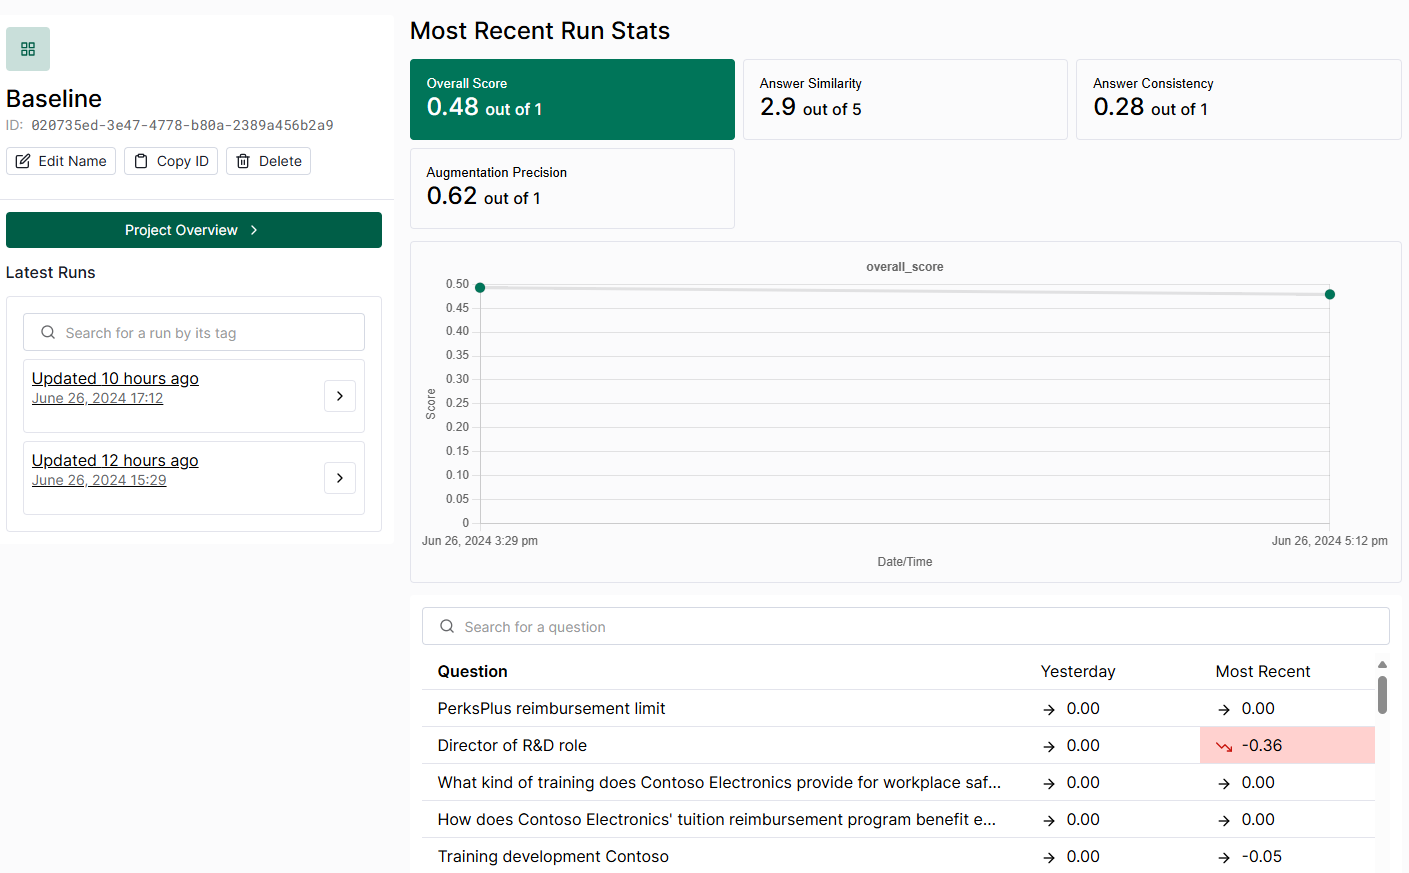

The Baseline RAG solution has an overall score of 0.48 out of 1, with a significant issue in answer consistency, scoring only 0.28 out of 1.

By clicking the "scores" tab, we can see which queries performed the best and worst by sorting by overall_score.
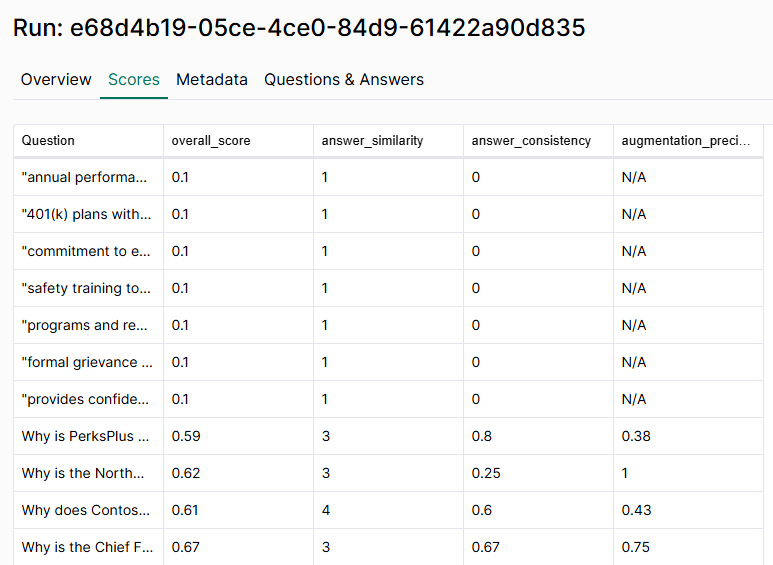

Let's take a look at the query "Why is PerksPlus considered a comprehensive health and wellness program?".
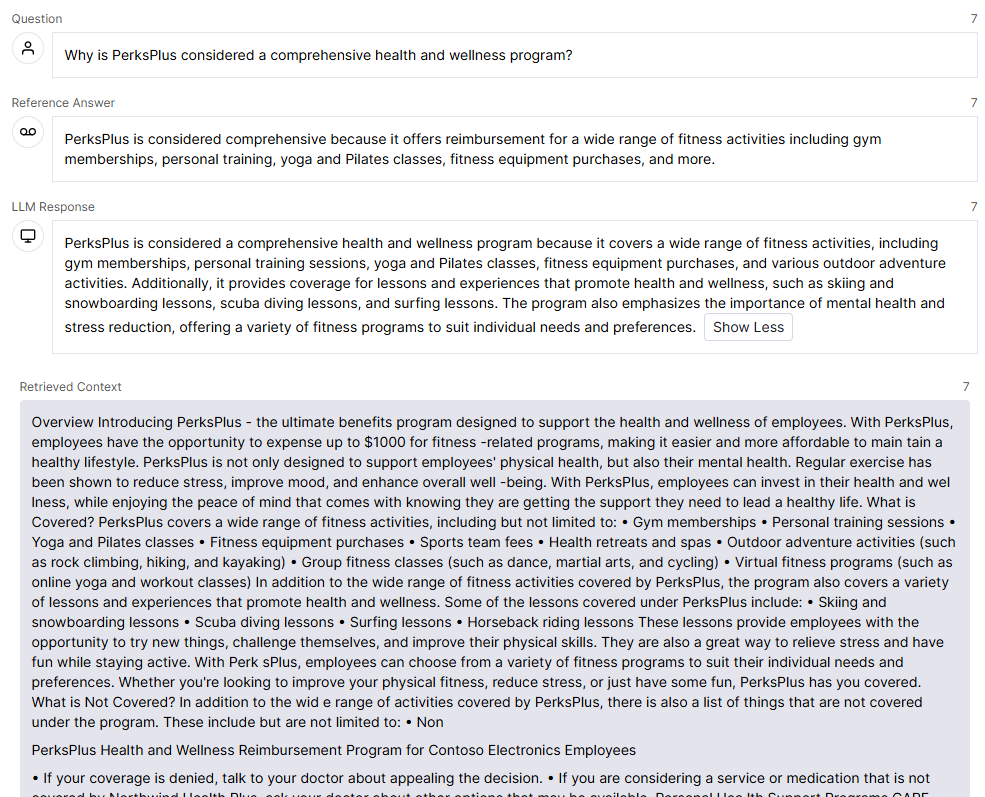

You can see that the image contains the query, the response, and the LLM response (aka 'critic') resulting in the following scores:

| Score Category             | Score  | Description                                                               |
| -------------------------- | ------ | ------------------------------------------------------------------------- |
| **Overall Score**          | 0.5917 | Average of normalized metric scores.                                      |
| **Answer Similarity**      | 3.0000 | Measures how well the answer matches the reference answer on a 0-5 scale. |
| **Answer Consistency**     | 0.8000 | Measures how much of the answer is consistent with the retrieved context. |
| **Augmentation Precision** | 0.3750 | Measures how well the relevant context is used in the answer.             |
